# Adams 2021 Summer Assignment

Idil Ugurnal

Enrollment no: 614221

## Table of Contents

    1. Introduction
    2. Data Loading and Cleaning
        2.1 Importing Libraries and Defining Helper Methods
        2.2 Loading the Data
        2.3 Explaining and Cleaning the Data
    3. Training and Prediction
        3.1 Model Training with Non-Text Data
            3.1.1 Gradient Boosting Regressor with Cross Validation
            3.1.2 Random Forest with Cross Validation
            3.1.3 XGBoost with Cross Validation
            3.1.4 Prediction with Test Data
            3.1.5 Grid Search
        3.2 NLP & RNN Architecture
            3.2.1 Clean Text Data
            3.2.2 LSTM
            3.2.3 Prediction with Test Data
        3.3 Full Model Architecture
            3.3.1 Data Preparation
            3.3.2 Prediction with Test Data
    4. Conclusion

## 1. Introduction

The goal of this project is to predict the price of a airbnb listing. The data is a real data taken from airbnb London city. The data consists of numerical, boolean and textual features. Text features include description, summary, house_rules etc. There are some categorical values such as host_response_time or room_type which can be transferred and be represented as numerical data. Numerical features are features such as number of bathrooms, bedrooms, beds etc.

For training, the data training.csv and for testing, the data test.csv will be utilized.

In this assignment, we will analyze the data, clean it and with this data, we will use regression and NLP techniques to predict Airbnb listings' prices.

## 2. Data Loading and Cleaning

### 2.1 Importing libraries and defining helper methods

Now we will import some libraries that are necessary for the comletion of this assignment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import re
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger'])
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from nltk.corpus import stopwords
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import FunctionTransformer

from matplotlib import pyplot
from xgboost import plot_importance

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



import re
import time
import pickle
from bs4 import BeautifulSoup

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/idilugurnal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/idilugurnal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/idilugurnal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/idilugurnal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Below are helper functions necessary to clean data, do training and prediction.

The method below drops multiple columns in a data frame

In [2]:
def drop_columns(df, to_be_dropped):
    df.drop(inplace=True, columns=to_be_dropped)

The method below fills nan values with the mean of the column.

In [3]:
def fill_with_mean(df, nan_list):
    for col in nan_list:
        df[col].fillna(df[col].mean(), inplace=True)

The method below fills nan values with the median of the column.

In [4]:
def fill_with_median(df, nan_list):
    for col in nan_list:
        df[col].fillna(df[col].median(), inplace=True)

The method below encodes the categorical columns in order to train

In [5]:
def columns_to_encode(df, cols):
    for field in cols:
        le = preprocessing.LabelEncoder()
        df[field] = le.fit_transform(df[field])

The method below gets histogram of a distribution of data in a column.

In [6]:
def get_histogram(title,data):
    x = list(data.value_counts().keys())
    x = x[::-1]
    y = list(data.value_counts())
    y = y[::-1]
    plt.barh(x,y)
    plt.title(title)
    return None

The method below is to summarize the 3 most frequent value in a column.

In [7]:
def field_summary(column, data):
    get_histogram(column + " histogram", data[column])
    print(column,'description\n', data[column].describe())
    print('Top 3 frequent:',data[column].value_counts()[:3].index.tolist())

The functions `review_100_func` and `review_10_func` are separating reviews into 5 distinct groups. `cancellation_function`also devides the data into three groups. Finally the `property_function` divides the property type into five distinct groups. These are done in order to have more meaningful data and have better training results.

In [8]:
def review_100_fnc(review):
    
    if review == 100:
        return "100"
    elif review >= 90:
        return "90-99"
    elif review >= 80:
        return "80-89"
    elif review >= 70:
        return "70-79"
    else:
        return "0-69"
    
def review_10_fnc(review):
    
    if review == 10:
        return "10"
    elif review == 9:
        return "9"
    elif review >= 7:
        return "7-8"
    else:
        return "0-7"

def cancellation_function(property):
    
    if property in strict:
        return "strict"
    elif property in moderate:
        return "moderate"
    elif property == "flexible":
        return property
    
def property_function(property):
    
    if property in luxury:
        return "Luxury"
    elif property in apartment:
        return "Apartment"
    elif property == "House":
        return property
    else:
        return "Other"

### 2.2 Loading Data

First we read the train and test data and see the columns they have below. It can be seen that the test data does not have the column 'price' which is what we are trying to compute.
We don't read the reviews data here which will be utilized later on.

In [9]:
train = pd.read_csv("data/train.csv", sep=",", encoding="utf-8", index_col="listing_id")
test = pd.read_csv("data/test.csv", sep=",", encoding="utf-8", index_col="listing_id")

Now we see the head of train data, and few columns

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55284 entries, 9Q1RD6H7IO to BKSRYBXCFL
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         55270 non-null  object 
 1   summary                      52330 non-null  object 
 2   space                        38403 non-null  object 
 3   description                  53558 non-null  object 
 4   experiences_offered          55284 non-null  object 
 5   neighborhood_overview        35778 non-null  object 
 6   transit                      35477 non-null  object 
 7   house_rules                  31906 non-null  object 
 8   picture_url                  55284 non-null  object 
 9   host_id                      55284 non-null  int64  
 10  host_since                   55173 non-null  object 
 11  host_response_time           37482 non-null  object 
 12  host_response_rate           37482 non-null  object 
 13  host_is

In [11]:
train

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month
listing_id,,,,,,,,,,,,,,,,,,,,,
9Q1RD6H7IO,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,...,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37
6XDPZPGLSR,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,https://a0.muscache.com/im/pictures/8d1ddcdc-f...,16148175,...,2,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97
SND9OPN6IY,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,https://a0.muscache.com/im/pictures/e7e4a740-d...,272000199,...,2,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73
SE3B7BXN9G,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,none,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...,https://a0.muscache.com/im/pictures/7c2b2fcc-e...,3361233,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN
E0C82VK0VF,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",none,NaN,NaN,"I am very happy for your visit, but please car...",https://a0.muscache.com/im/pictures/ca1494da-f...,94317022,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HSY40NEHOI,"Brixton/Camberwell DBL bedroom, brand new flat",Large private double bedroom available in a br...,NaN,Large private double bedroom available in a br...,none,Situated smack bang in the centre of south Lon...,Loughbrough Junction Station (Thameslink Line)...,Take shoes off at the door No food or drink on...,https://a0.muscache.com/im/pictures/f79f4455-2...,28354624,...,1,100.0,10.0,10.0,10.0,10.0,9.0,10.0,strict_14_with_grace_period,0.20
XZXB1NS63Y,End suite with private bathroom. Close to the ...,NaN,Private end suite with smart TV and PlayStatio...,Private end suite with smart TV and PlayStatio...,none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/f7f0103a-e...,207619004,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,0.08
Z2T8G6D82D,The place full of a good energy!,3 double bedroom APARTMENT for families and fr...,"Warm, clean and safe, close to city atractions...",3 double bedroom APARTMENT for families and fr...,none,"Location, location, location: Local amenities:...","Direct, convenient and quick 20 mins access to...",- SMOKING is STRICTLY FORBIDDEN at the buildin...,https://a0.muscache.com/im/pictures/11207118-1...,137970479,...,2,96.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,1.60


And now we see test data

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29769 entries, 0FEMC4VA5U to YOCQ63ZYYD
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         29759 non-null  object 
 1   summary                      28192 non-null  object 
 2   space                        20712 non-null  object 
 3   description                  28826 non-null  object 
 4   experiences_offered          29769 non-null  object 
 5   neighborhood_overview        19218 non-null  object 
 6   transit                      19097 non-null  object 
 7   house_rules                  17189 non-null  object 
 8   picture_url                  29769 non-null  object 
 9   host_id                      29769 non-null  int64  
 10  host_since                   29704 non-null  object 
 11  host_response_time           20197 non-null  object 
 12  host_response_rate           20197 non-null  object 
 13  host_is

### 2.3 Explaining and Cleaning the Data

####  Description of train data

Now we will dive deeper into the columns of the train data to see which column is meaningful for price prediction and which column is unnecessary. After, the unnecessary columns will be dropped.

In [13]:
train.describe(include="all")

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month
count,55270,52330,38403,53558,55284,35778,35477,31906,55284,5.528400e+04,...,55284.000000,41869.000000,41836.000000,41842.000000,41801.000000,41838.000000,41804.000000,41804.000000,55284,42904.000000
unique,54042,49111,35719,51626,5,30233,31098,24790,54423,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN
top,Double room,"Featured in The New York Times, The Wall Stree...",Situated in an excellent central location. Tow...,My Luxury Two Bedroom apartment is located min...,none,Conveniently located in Maida Vale one of Lond...,Transport links are excellent with convenient ...,- The lead guest will be required to sign an O...,https://a0.muscache.com/im/pictures/d029c664-c...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict_14_with_grace_period,NaN
freq,28,125,20,17,54222,40,47,210,7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24102,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.817998e+07,...,1.574832,92.533044,9.502868,9.261484,9.622043,9.652851,9.541623,9.262846,NaN,1.164464
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.013224e+07,...,1.263427,10.030620,0.982464,1.138548,0.894931,0.873805,0.810408,1.033351,NaN,1.353820
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.697000e+03,...,1.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,0.010000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.526397e+07,...,1.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,0.240000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.816502e+07,...,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,0.730000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.449050e+08,...,2.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.570000


Now we will visualize the number of null data we have for each column. We will get help from the describe functionality of pandas dataframe. Looking at the figure above, we can see that for `experiences_offered`, we have a object 'none' value. We will replace this with NaN in order for better processing.

name                              14
summary                         2954
space                          16881
description                     1726
experiences_offered            54222
neighborhood_overview          19506
transit                        19807
house_rules                    23378
picture_url                        0
host_id                            0
host_since                       111
host_response_time             17802
host_response_rate             17802
host_is_superhost                111
host_total_listings_count        111
host_has_profile_pic             111
host_identity_verified           111
neighbourhood                    147
neighbourhood_cleansed             0
zipcode                         1272
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         70
bedrooms                          62
b

<AxesSubplot:>

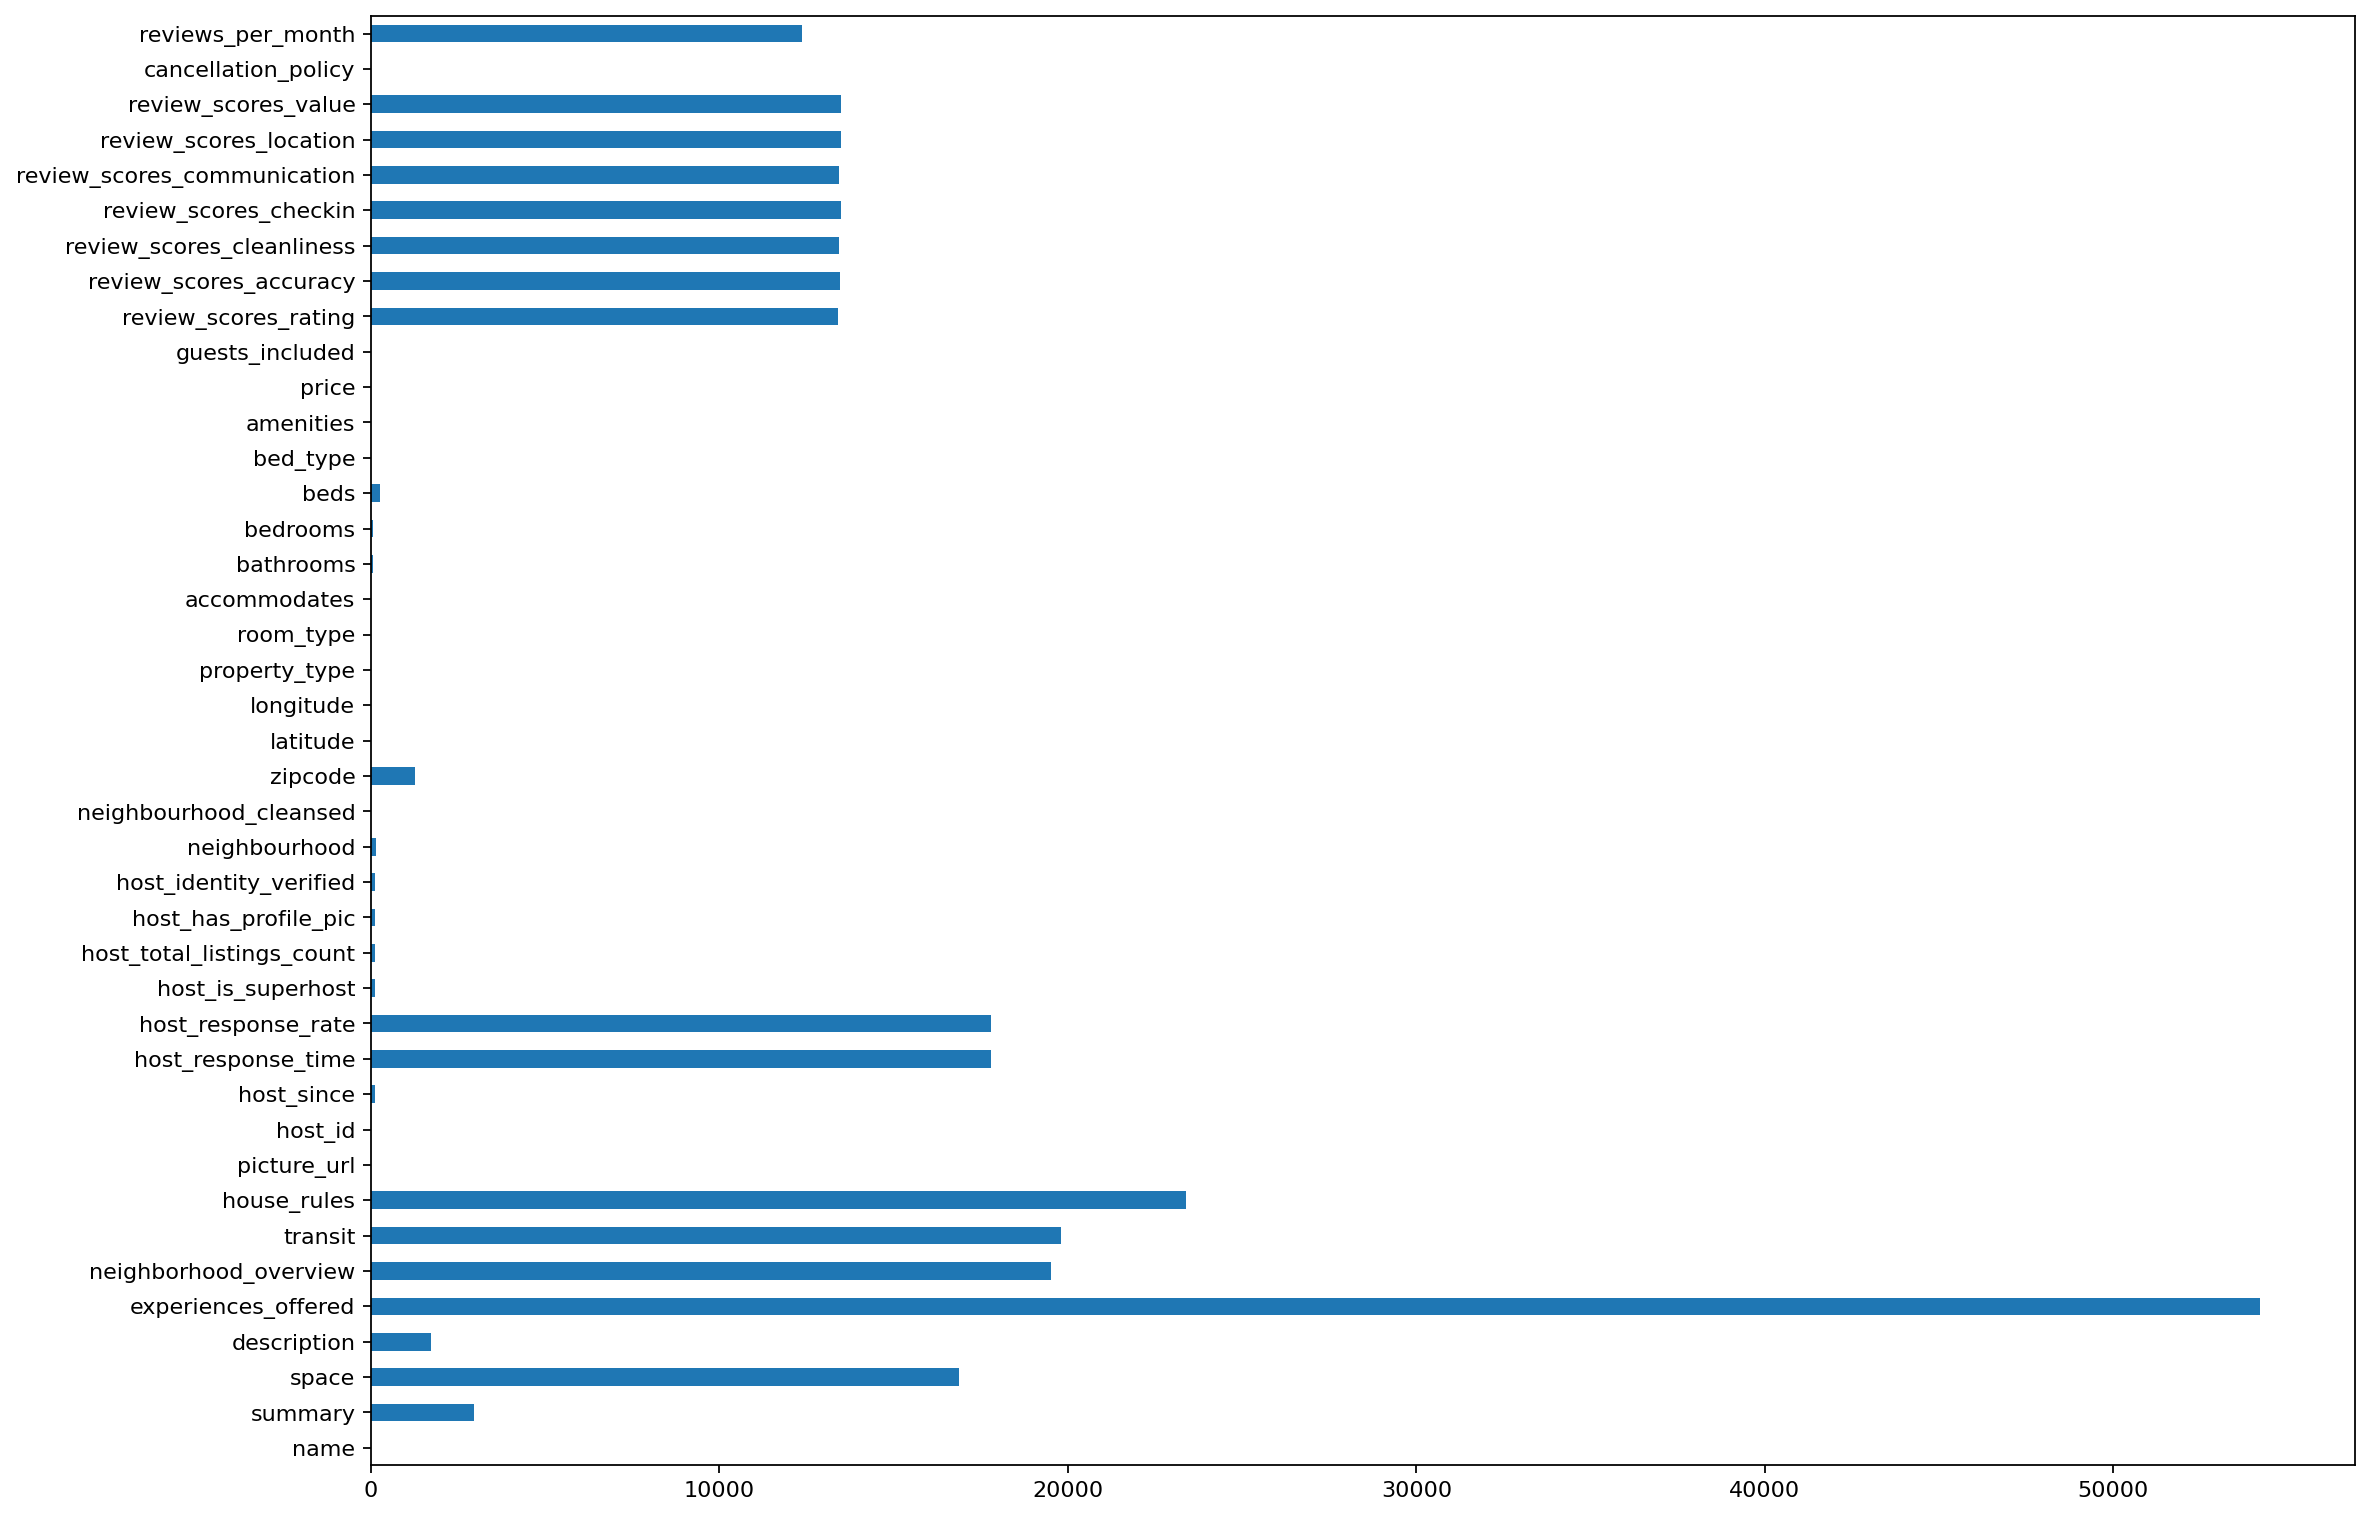

In [14]:
train = train.replace("none" , np.nan)
print(train.isnull().sum())
test = test.replace("none" , np.nan)
plt.figure(figsize=(16, 12), dpi=160)
train.isnull().sum().plot.barh()

##### Looking at the data above, we can deduct:

1. Most of the values for `experiences_offered` field are null. It could be removed.
2. `host_total_listings_count` has a high standard deviation. This could mean outliers. Also its top freq is NaN</li>
3. `host_response_time` is "within an hour" for majority of the case.</li>
4. `host_response_rate` is "100%" for 66%.</li>
5. `host_has_profile_pic` is almost always true.</li>    

There is of course more to discuss but for now we will start with these. Lets further investigate these 5 fields.

#### Column: `experiences_offered`

This column represents the type of experience offered in the listing. Now we will demonstrate the distribution of values in this column

experiences_offered description
 count         1062
unique           4
top       business
freq           364
Name: experiences_offered, dtype: object
Top 3 frequent: ['business', 'family', 'social']


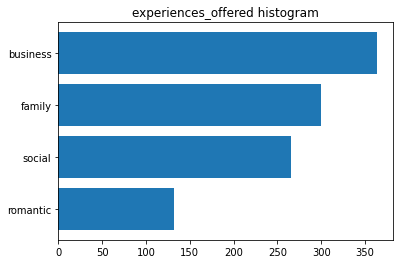

In [15]:
field_summary('experiences_offered', train)

The figure above shows the distribution without the nan values. Now let's see this field with none values added:

<AxesSubplot:ylabel='experiences_offered'>

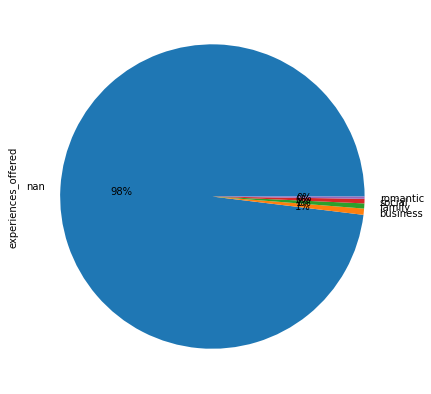

In [16]:
train['experiences_offered'].value_counts(dropna=False).plot.pie(autopct='%1.0f%%',  figsize=(7,7))

As can be seen, 98% of the values are null. Therefore, this column has no meaning when training the data. We will drop this column and continue.

In [17]:
drop_columns(train, ['experiences_offered'])
drop_columns(test, ['experiences_offered'])

#### Column: `host_total_listings_count`

This column represents the number of listing a specific host has. 

111

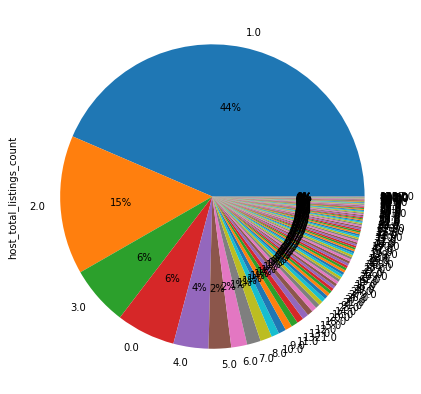

In [18]:
train['host_total_listings_count'].value_counts(dropna=False).plot.pie(autopct='%1.0f%%',  figsize=(7,7))
train['host_total_listings_count'].isna().sum()

We can see that, the majority of the value for `host_total_listings_count` is 1. However, the ratio of 1 to the entire data is less than 50%. We will fill the none values of this column with the median. This column will not be dropped.

In [19]:
fill_with_median(train, ['host_total_listings_count'])
fill_with_median(test, ['host_total_listings_count'])

#### Column: `host_response_time`

This column represents the response time of the listing host. This is a categorical variable.

17802

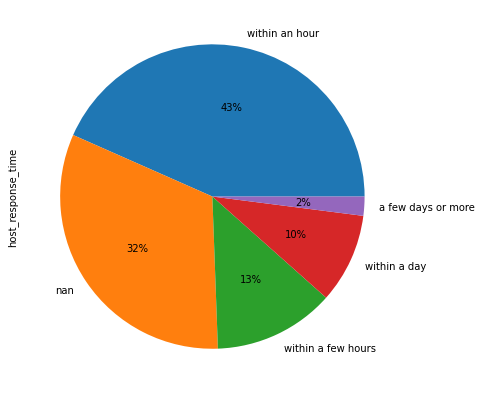

In [20]:
train['host_response_time'].value_counts(dropna=False).plot.pie(autopct='%1.0f%%',  figsize=(7,7))
train['host_response_time'].isna().sum()

`host_response_time` has 17802(%32) NaN values. These will also be filled with median value and the values will be converted to integer.

In [21]:
columns_to_encode(train, ['host_response_time'])
columns_to_encode(test, ['host_response_time'])

fill_with_median(train, ['host_response_time'])
fill_with_median(test, ['host_response_time'])

<AxesSubplot:ylabel='host_response_time'>

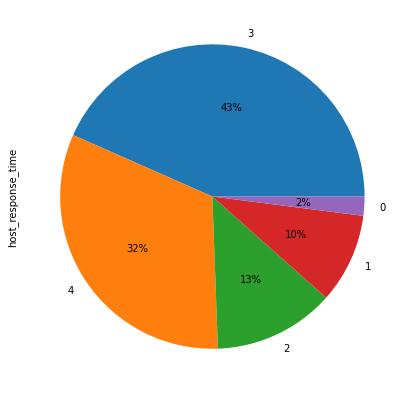

In [22]:
train['host_response_time'].value_counts(dropna=False).plot.pie(autopct='%1.0f%%',  figsize=(7,7))

#### Column: `host_response_rate`

This column represents the response rate of the listing host. This is a categorical variable. The values range between 1-100 percent. It is better to convert this field to a more meaningful representation. Instead of a range of percentage values, we will convert this field to categories. The categories are explained below.

<AxesSubplot:ylabel='host_response_rate'>

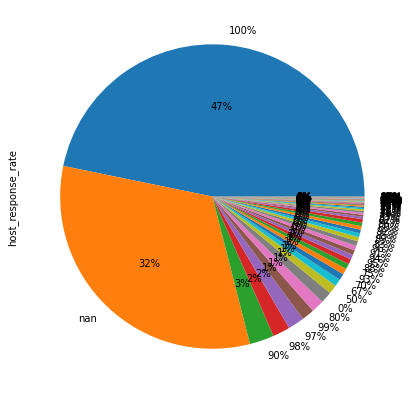

In [23]:
train['host_response_rate'].value_counts(dropna=False).plot.pie(autopct='%1.0f%%',  figsize=(7,7))

We will group these percentages and add an additional category for Nan values. We will have a total of 5 categories:
1. Not given
2. 0-50%
3. 51-80%
4. 81-99%
5. 100%

In [24]:
train['host_response_rate'] = train['host_response_rate'].str[:-1].astype('float64')
criteria = [train['host_response_rate'].between(0,50), train['host_response_rate'].between(51,85), train['host_response_rate'].between(86,99), train['host_response_rate'].between(100,101)]
values = ["0-50%" , "51-85%", "86-99%", "100%"]
train['host_response_rate'] =np.select(criteria, values, "not given")
columns_to_encode(train, ['host_response_rate'])


test['host_response_rate'] = test['host_response_rate'].str[:-1].astype('float64')
criteria = [test['host_response_rate'].between(0,50), test['host_response_rate'].between(51,85), test['host_response_rate'].between(86,99), test['host_response_rate'].between(100,101)]
values = ["0-50%" , "51-85%", "86-99%", "100%"]
test['host_response_rate'] =np.select(criteria, values, "not given")
columns_to_encode(test, ['host_response_rate'])

<AxesSubplot:ylabel='host_response_rate'>

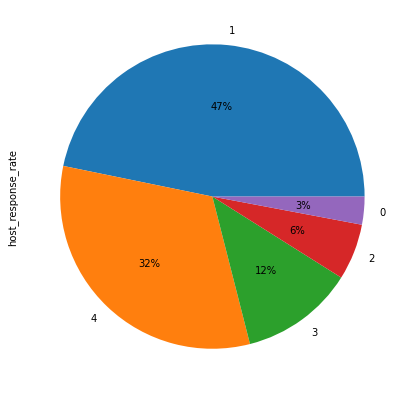

In [25]:
train['host_response_rate'].value_counts(dropna=False).plot.pie(autopct='%1.0f%%',  figsize=(7,7))

Above is the new distribution of the five given categories. 

#### Column: `host_has_profile_pic`

This field explains if the host has a profile picture or not. Below the distribution can be observed.

<AxesSubplot:ylabel='host_has_profile_pic'>

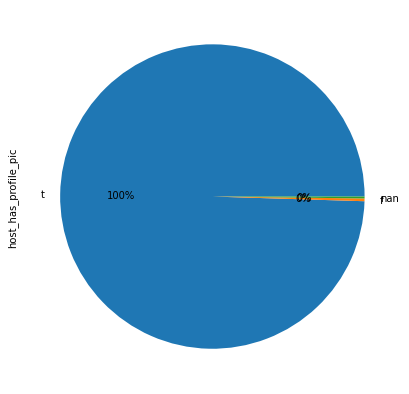

In [26]:
train['host_has_profile_pic'].value_counts(dropna=False).plot.pie(autopct='%1.0f%%',  figsize=(7,7))

This field is mostly NaN therefore it will be dropped.

In [27]:
drop_columns(train, ['host_has_profile_pic'])
drop_columns(test, ['host_has_profile_pic'])

In [28]:
train.columns

Index(['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'transit', 'house_rules', 'picture_url', 'host_id', 'host_since',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month'],
      dtype='object')

Below columns are processed up until now. After this stage, we will continue with other columns

1. `experiences_offered` 
2. `host_total_listings_count`
3. `host_response_time`
4. `host_response_rate` 
5. `host_has_profile_pic`   

#### Columns: `neighbourhood`, `neighbourhood_cleansed`,`zipcode`, `latitude`, `longitude`

Since all these fields are address locaition information, only one will be left and the others will be dropped for more meaningful result. We choose `neighbourhood_cleansed` to keep. The reason is, `neighbourhood_cleansed` is clean information about the neighbourhood area, it is more meaningful to use when compared to `neighbourhood` alone. This column is also categorical.

In [29]:
columns_to_drop = ['neighbourhood', 'zipcode', 'latitude', 'longitude']
drop_columns(train, columns_to_drop)
drop_columns(test, columns_to_drop)

#### Textual data

Initially at this stage, we will look at non-textual data. After training with non-text data, we will explore text fields and train them separately and then combine models. At this stage, text data will not be used. With text data, some other columns will be dropped at this moment that are string objects and with them, the `picture_url` and `host_id` will also be dropped.

In [30]:
columns_to_drop = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'host_id', 'picture_url', 'transit', 'house_rules']
drop_columns(train, columns_to_drop)
drop_columns(test, columns_to_drop)

#### Column: `host_since`

`host_since` represents the amount of time the host spent on AirBNB. We will convert this field to the number of days from host's registration (`host_since` value) until today for better processing

For now we drop host_since but this will be added later on.

In [31]:
def date_to_day(x, cur_day):
    if isinstance(x,str) and re.search("\d{4}-\d{2}-\d{2}", x):
        a = datetime.strptime(cur_date, '%Y-%m-%d')
        b = datetime.strptime(x, '%Y-%m-%d')
        return (a - b).days
    else:
        return -1

In [32]:
from datetime import datetime
cur_date = '2021-06-01'
train['host_since'].dropna(inplace=True)
train['host_since'] = train['host_since'].apply(lambda x: date_to_day(x, cur_date))

test['host_since'].dropna(inplace=True)
test['host_since'] = test['host_since'].apply(lambda x: date_to_day(x, cur_date))

In [33]:
train['host_since'] = train['host_since'].apply(lambda x: x if (x > 0) else train['host_since'].median())
train['host_since'] = train['host_since'].apply(lambda x: x if (x > 0) else train['host_since'].median())

#### Column: `amenities`

Amenities are the things a listing supports such as Dryer of WiFi etc. Not all amenities will be used, we choose 19-20 important amenities, and use one-hot encoding to represent if a listing has a specific amenity or not.

In [34]:
train['amenities'].value_counts()

amenities = dict()

for instance in train['amenities']:
    instance = instance[1:-1].split(",")
    for i in range(0, len(instance)):
        instance[i] = instance[i].strip("\"")
    for amenity in instance:
        if amenity in amenities.keys():
            amenities[amenity] = amenities[amenity] + 1
        else:
            amenities[amenity] = 1

for instance in test['amenities']:
    instance = instance[1:-1].split(",")
    for i in range(0, len(instance)):
        instance[i] = instance[i].strip("\"")
    for amenity in instance:
        if amenity in amenities.keys():
            amenities[amenity] = amenities[amenity] + 1
        else:
            amenities[amenity] = 1

Below, the number of occurence of each amenity is given. 

In [35]:
sorted(amenities.items(), key=lambda x: x[1], reverse=True)

[('Wifi', 81647),
 ('Heating', 80518),
 ('Essentials', 79514),
 ('Kitchen', 77704),
 ('Smoke detector', 73478),
 ('Washer', 72516),
 ('Hangers', 68238),
 ('Iron', 65017),
 ('Hair dryer', 59883),
 ('Shampoo', 58118),
 ('TV', 57984),
 ('Laptop friendly workspace', 53602),
 ('Carbon monoxide detector', 50392),
 ('Hot water', 48163),
 ('Dryer', 37113),
 ('Refrigerator', 36114),
 ('Dishes and silverware', 34070),
 ('Oven', 31912),
 ('Bed linens', 31080),
 ('Microwave', 30110),
 ('Cooking basics', 30021),
 ('Stove', 28650),
 ('Fire extinguisher', 27143),
 ('First aid kit', 26855),
 ('Family/kid friendly', 22967),
 ('Private entrance', 20698),
 ('Lock on bedroom door', 20069),
 ('Dishwasher', 19478),
 ('Internet', 18916),
 ('Long term stays allowed', 18872),
 ('Elevator', 18783),
 ('Coffee maker', 18007),
 ('Free parking on premises', 15599),
 ('Host greets you', 15350),
 ('Extra pillows and blankets', 15086),
 ('Self check-in', 13589),
 ('Cable TV', 13020),
 ('Luggage dropoff allowed', 12862

In the amenity_set, important amenities are chosen.

In [36]:
amenity_set = ['Dishes and silverware', 'TV', 'Hot water','Refrigerator', 'Oven', 'Microwave','Stove',
                 'Dishwasher', 'Coffee maker', 'Private living room', 'Patio or balcony', 'Breakfast' ,
               'Garden or backyard', 'Bathtub','Air conditioning', 'Safety card', '24-hour check-in',
               'BBQ grill', 'Gym'
              ]

In [37]:
for amenity in amenity_set:
    train[amenity] = train['amenities'].apply(lambda x: amenity in x).astype(int)
    
for amenity in amenity_set:
    test[amenity] = test['amenities'].apply(lambda x: amenity in x).astype(int)
    

After one-hot encoding, we drop the original amenities column, since now we have the information of each entity represented with a boolean value.

In [38]:
drop_columns(train, ['amenities'])
drop_columns(test, ['amenities'])

#### Other columns

We have some boolean values in columns. These are represented with `t` and `f`. We replace t with 1 and f with 0. In addition, here the nan values for reviews are filled with minimum value since the missing data would be more close to a low score rather than a median or mean. If a listing has no review, that is a negative impression.  

In [39]:
#Replace t, f with 1 and 0 respectively
train.replace({'f': 0, 't': 1}, inplace=True)
train.host_response_time.fillna("unknown", inplace=True)
for col in ['reviews_per_month', 'host_is_superhost', 'host_identity_verified','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'bathrooms', 'bedrooms', 'beds', 'host_total_listings_count']:
    train[col].fillna(train[col].min(), inplace=True)
      
    
test.replace({'f': 0, 't': 1}, inplace=True)
test.host_response_time.fillna("unknown", inplace=True)
for col in ['reviews_per_month', 'host_is_superhost', 'host_identity_verified','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'bathrooms', 'bedrooms', 'beds', 'host_total_listings_count']:
    test[col].fillna(train[col].min(), inplace=True)

#### column `property_type`

This field represents the type of the property such as apartment house etc. This also is categorical. There are too many categories so we limit the categories to 3:
1. luxury
2. apartment
3. house

In [40]:
train.groupby('property_type').count()
luxury = ["Boat", "Boutique hotel", 'Chalet', 'Earth house','Dome house','Guest suite','Houseboat','Island','Villa', "Luxury"]
apartment = ['Condominium', 'Apartment','Serviced apartment','Loft']
house= ['House']

train['property_type'] = train['property_type'].apply(lambda x: property_function(x))
test['property_type'] = test['property_type'].apply(lambda x: property_function(x))

#### column `cancellation_policy`

This field represents the cancellation policy. It is also categorical and the categories are decreased to two which are strict and moderate.

In [41]:
strict = ['super_strict_30', 'super_strict_60','strict_14_with_grace_period','luxury_super_strict_95','strict']
moderate= ['moderate', 'luxury_moderate']

train['cancellation_policy'] = train['cancellation_policy'].apply(lambda x: cancellation_function(x))
test['cancellation_policy'] = test['cancellation_policy'].apply(lambda x: cancellation_function(x))

#### column `bed_type`

The type of bed is also categorical and for better meaning, the `bed_type` categories are reduced to 2 which are Real Bed or not Real Bed.

In [42]:
train['bed_type'] = train['bed_type'].apply(lambda x: x == "Real Bed" ).astype(int)
test['bed_type'] = test['bed_type'].apply(lambda x: x == "Real Bed" ).astype(int)

#### Encode columns

Columns below are categorical and need to be encoded before they can be trained. 

In [43]:
columns_to_encode(train, ['host_response_time',"neighbourhood_cleansed", "property_type", "room_type","cancellation_policy"])
columns_to_encode(test, ['host_response_time',"neighbourhood_cleansed", "property_type", "room_type","cancellation_policy"])

## Training and Prediction

### 3.1 Training non-text data

First, we split the data and the label (price).

In [44]:
train_x = train.drop(columns=['price'])
train_y = train['price']

Now we check the data types of columns. They need to be numerical in order to train successfuly at this point.

In [45]:
pd.set_option('display.max_rows', 500)
train_x.dtypes

host_since                     float64
host_response_time               int64
host_response_rate               int64
host_is_superhost              float64
host_total_listings_count      float64
host_identity_verified         float64
neighbourhood_cleansed           int64
property_type                    int64
room_type                        int64
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                         int64
guests_included                  int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
cancellation_policy              int64
reviews_per_month              float64
Dishes and silverware            int64
TV                       

#### Normalization

Since each column has different number of categories or different range of values, it is important to normalize the trainig data to achieve a meaningful result. Below are the columns that are chosen for normalization.

In [46]:
to_normalize = ['host_since', 'host_total_listings_count', 'accommodates', 'review_scores_rating', 
                'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

#### Normalize training data

In [47]:
#normalized_x = train_x
normalized_x = train_x[to_normalize]
std_scale = preprocessing.MinMaxScaler().fit(normalized_x)
train_x_norm = std_scale.transform(normalized_x)

training_norm_col = pd.DataFrame(train_x_norm, index=normalized_x.index, columns=normalized_x.columns) 
train_x.update(training_norm_col)
print (train_x.head())
train_non_text = train_x

            host_since  host_response_time  host_response_rate  \
listing_id                                                       
9Q1RD6H7IO    0.680743                   3                   1   
6XDPZPGLSR    0.494691                   2                   1   
SND9OPN6IY    0.046815                   3                   1   
SE3B7BXN9G    0.649855                   2                   1   
E0C82VK0VF    0.293436                   3                   1   

            host_is_superhost  host_total_listings_count  \
listing_id                                                 
9Q1RD6H7IO                1.0                   0.000757   
6XDPZPGLSR                1.0                   0.000757   
SND9OPN6IY                0.0                   0.001514   
SE3B7BXN9G                0.0                   0.000757   
E0C82VK0VF                1.0                   0.001514   

            host_identity_verified  neighbourhood_cleansed  property_type  \
listing_id                             

#### Normalize test data

In [48]:
#normalized = test
normalized = test[to_normalize]
x_test_norm = std_scale.transform(normalized)
testing_norm_col = pd.DataFrame(x_test_norm, index=normalized.index, columns=normalized.columns) 
test.update(testing_norm_col)
print (test.head())
test_non_text = test

            host_since  host_response_time  host_response_rate  \
listing_id                                                       
0FEMC4VA5U    0.430019                   4                   4   
PQ2BYEO0QR    0.489865                   3                   1   
3FP6WFHUBN    0.624035                   4                   4   
GG0V2KDG90    0.570222                   4                   4   
TZVVK4YSIO    0.437017                   0                   0   

            host_is_superhost  host_total_listings_count  \
listing_id                                                 
0FEMC4VA5U                0.0                   0.000757   
PQ2BYEO0QR                1.0                   0.010598   
3FP6WFHUBN                0.0                   0.000757   
GG0V2KDG90                0.0                   0.000757   
TZVVK4YSIO                0.0                   0.002271   

            host_identity_verified  neighbourhood_cleansed  property_type  \
listing_id                             

### 3.1.1 GradientBoostingRegressor with Cross Validation

In [48]:
model_gb = GradientBoostingRegressor(learning_rate= 0.02, max_depth= 10, n_estimators= 500, subsample= 0.7, verbose=2)
kfold = KFold(n_splits=5)
results_gb = cross_val_score(model_gb, train_x, train_y, cv=kfold, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=4)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1        6801.7782         165.4412            2.74m
         2        6654.1537         156.9619            2.63m
         3        6400.3702         154.5591            2.57m
         4        6371.6177         145.7533            2.55m
         5        6094.1930         145.9046            2.54m
         6        5959.5841         135.1044            2.52m
         7        5831.3431         130.2785            2.52m
         8        5686.2466         126.7817            2.53m
         9        5466.4508         117.4749            2.51m
        10        5408.7291         117.2523            2.50m
        11        5297.5828         113.8061            2.58m
        12        5197.2169         105.7716            2.57m
        13        5127.7460          98.0185            2.56m
        14        4914.0205         100.1064            2.54m
        15        4832.8593          93.6955            2.54m
       

       132        1444.1582           2.1672            2.05m      Iter       Train Loss      OOB Improve   Remaining Time 
         1        6888.6797         165.3448            2.67m
         2        6674.6351         157.9206            2.61m
         3        6477.5735         152.5974            2.56m
         4        6327.9685         150.5324            2.55m
         5        6193.3610         140.1635            2.54m
         6        5964.9269         138.9373            2.52m
         7        5831.1217         135.4391            2.51m
         8        5857.6944         121.6176            2.50m
         9        5527.8067         125.9263            2.49m
        10        5450.4098         119.7760            2.48m
        11        5308.8687         113.4131            2.55m
        12        5197.1290         113.6631            2.54m
        13        5076.3480         105.3100            2.53m
        14        4976.0734         102.7560            2.52m
        

       132        1475.3264           1.8389            2.06m
       133        1448.6971           2.3120            2.05m
       134        1441.6547           1.6652            2.04m
       135        1416.4465           1.5072            2.04m
       136        1435.2169           1.6862            2.03m
       137        1409.2264           1.8463            2.02m
       138        1444.6884           1.5924            2.02m
       139        1405.7421           1.2707            2.01m
       140        1405.3808           1.5718            2.01m
       141        1400.7118           1.4601            2.00m
       142        1385.3210           1.9161            2.00m
       143        1399.7049           1.3048            1.99m
       144        1378.5703           1.7640            1.99m
       145        1366.7607           1.6423            1.98m
       146        1383.6622           0.8030            1.98m
       147        1368.0145           1.1082            1.97m
       1

       265         975.7784           0.0354            1.31m
       133        1423.6531           1.9031            2.05m
       134        1432.0571           1.5210            2.04m
       135        1438.0373           2.0515            2.04m
       136        1430.3243           1.4582            2.03m
       137        1413.0497           1.4369            2.02m
       138        1450.4047           1.6982            2.02m
       139        1409.9087           1.7317            2.01m
       140        1401.9676           1.1551            2.01m
       141        1399.2465           1.5895            2.00m
       142        1372.0882           1.4479            2.00m
       143        1392.5441           1.7997            1.99m
       144        1359.6788           1.5677            1.99m
       145        1391.9588           1.0195            1.98m
       146        1360.5496           1.2886            1.98m
       147        1346.7327           1.4978            1.97m
       1

       265         990.2858           0.1527            1.32m
       133        1473.9005           1.2922            2.05m
       134        1461.1785           1.6895            2.04m
       135        1449.7215           2.1946            2.04m
       136        1415.1766           1.6141            2.03m
       137        1394.2358           1.3616            2.02m
       138        1430.7570           1.9563            2.02m
       139        1444.9019           1.4037            2.01m
       140        1410.4215           1.3018            2.00m
       141        1433.7498           1.7296            2.00m
       142        1409.2082           1.3894            1.99m
       143        1398.8843           1.6517            1.99m
       144        1377.7489           1.5561            1.98m
       145        1400.7776           0.8932            1.98m
       146        1362.8612           1.1764            1.97m
       147        1370.1350           1.0762            1.97m
       1

       265         981.1881           0.1493            1.32m
       266        1000.5485           0.3181            1.31m
       267        1008.2922           0.1013            1.30m
       268        1000.6722           0.0913            1.30m
       269         981.7777          -0.1106            1.29m
       270         976.7185           0.2112            1.29m
       271         974.2614           0.1097            1.28m
       272         982.7086          -0.0024            1.28m
       273         974.2429          -0.4280            1.27m
       274         981.0715           0.1066            1.27m
       275         971.1160           0.3125            1.26m
       276         987.3996           0.2110            1.26m
       277         964.9097           0.1993            1.26m
       278         967.7300           0.1043            1.25m
       279         968.6143           0.0026            1.25m
       280         954.0417           0.1511            1.24m
       2

       398         775.3960          -0.0128           36.85s
       399         780.2927          -0.0673           36.48s
       400         781.0472          -0.0283           36.12s
       401         789.1127          -0.0757           35.75s
       402         770.7305          -0.0917           35.37s
       403         767.6047          -0.2160           35.00s
       404         771.6142          -0.1874           34.62s
       405         776.7750          -0.1247           34.25s
       406         762.1321          -0.0069           33.87s
       407         767.6336          -0.0707           33.50s
       408         771.9114          -0.1399           33.12s
       409         769.6084          -0.2135           32.75s
       410         760.2775           0.0583           32.38s
       411         755.4244          -0.2915           32.01s
       412         761.3092          -0.0611           31.63s
       413         736.5422          -0.1021           31.26s
       4

        28        3770.0023          60.3447            1.56m
        29        3709.6921          55.0411            1.55m
        30        3693.3170          56.0962            1.56m
        31        3608.3933          49.4494            1.55m
        32        3536.3340          51.3866            1.54m
        33        3463.8244          47.1530            1.54m
        34        3431.2578          45.2380            1.54m
        35        3347.7489          43.9557            1.53m
        36        3346.2101          44.0959            1.53m
        37        3312.6385          42.3556            1.53m
        38        3260.8472          41.5837            1.53m
        39        3170.3681          39.6854            1.52m
        40        3158.6548          39.1125            1.52m
        41        3062.9582          38.2843            1.51m
        42        3078.6161          33.8021            1.51m
        43        3022.9651          34.3628            1.51m
        

       161        1296.4113           0.6127            1.05m
       162        1296.5156           0.8024            1.05m
       163        1310.9563           0.8212            1.05m
       164        1292.0691           1.1150            1.04m
       165        1279.7910           1.1843            1.04m
       166        1256.4255           1.0705            1.04m
       167        1266.7744           0.9239            1.03m
       168        1239.4850           0.8477            1.03m
       169        1241.1660           0.7775            1.03m
       170        1281.1097           0.7180            1.02m
       171        1246.0211           1.3282            1.02m
       172        1236.8265           1.0866            1.02m
       173        1223.3289           0.5302            1.01m
       174        1204.6477           0.8926            1.01m
       175        1240.6885           0.1244            1.01m
       176        1241.6663           0.4922            1.00m
       1

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  4.7min finished


#### Cross Validation Results

In [49]:
print(results_gb.mean() * -1)

46.90828514345512


### 3.1.2 RandomForest with Cross Validation

In [50]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators = 250, random_state = 42,n_jobs=-1, verbose=2)
kfold = KFold(n_splits=5)
results_rf = cross_val_score(model_rf, train_x, train_y, cv=kfold, scoring='neg_root_mean_squared_error', verbose=3, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.3s



       266         968.4088           0.0476            1.31m
       267         966.0821           0.1537            1.31m
       268         995.5160          -0.0923            1.30m
       269         962.5394          -0.0302            1.29m
       270         971.4531           0.3213            1.29m
       271         963.3036           0.2424            1.29m
       272         975.9554           0.0869            1.28m
       273         950.8680           0.0578            1.28m
       274         971.1595           0.2211            1.27m
       275         965.1407          -0.2059            1.27m
       276         960.9686           0.1718            1.27m
       277         957.9112          -0.0069            1.26m
       278         966.1034          -0.1699            1.26m
       279         949.9369           0.1195            1.25m
       280         945.8128           0.2714            1.25m
       281         930.8058           0.0693            1.25m
       

       398         761.9552           0.1263           36.86s
       266         989.1089           0.2839            1.31m
       267         967.1507          -0.0787            1.31m
       268         963.7268           0.0805            1.30m
       269         966.7430           0.0420            1.29m
       270         951.1656          -0.0033            1.29m
       271         967.4821           0.0350            1.29m
       272         960.3609          -0.0445            1.28m
       273         957.1641          -0.0564            1.28m
       274         940.6924           0.0323            1.27m
       275         964.3826          -0.0328            1.27m
       276         945.9180           0.1461            1.27m
       277         946.6288           0.2068            1.26m
       278         931.2264           0.0362            1.26m
       279         946.0117           0.0537            1.25m
       280         948.9803           0.0927            1.25m
       2

       398         758.9708          -0.1113           36.91s
       295         930.6172          -0.0173           39.45s
       296         903.3001          -0.0833           39.26s
       297         901.6373          -0.0600           39.06s
       298         916.3818          -0.1576           38.87s
       299         909.8279           0.2237           38.67s
       300         896.0827          -0.0119           38.47s
       301         909.1715          -0.0584           38.32s
       302         893.1637          -0.0422           38.20s
       303         892.1928           0.0607           37.99s
       304         904.7907           0.0813           37.78s
       305         896.8235           0.0793           37.65s
       306         885.5419          -0.0335           37.45s
       307         875.5070           0.0955           37.25s
       308         883.8731          -0.2496           37.04s
       309         893.6741          -0.0033           36.84s
       3

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend Threading


       399         773.9539          -0.0724           36.51s
       400         767.2585          -0.2284           36.14s
       401         746.9970          -0.1432           35.77s
       402         749.9666          -0.0697           35.39s
       403         756.9960          -0.0563           35.02s
       404         747.2735          -0.1076           34.64s
       405         766.3521          -0.1205           34.27s
       406         744.9023          -0.1380           33.89s
       407         759.2837          -0.0824           33.51s
       408         736.7584          -0.0543           33.14s
       409         744.3726          -0.0964           32.76s
       410         759.5436          -0.0404           32.39s
       411         730.9688          -0.1794           32.01s
       412         738.4496          -0.1582           31.64s
       413         754.6047          -0.0207           31.26s
       414         737.1419          -0.1295           30.89s
       

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   50.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


#### Cross Validation Results

In [51]:
print(results_rf.mean() * -1)

49.758090284098806


### 3.1.3 XGBoost with Cross Validation

In [52]:
model_xgb = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.035, max_depth= 10, min_child_weight= 5, n_estimators= 500, nthread= -1, objective='reg:squarederror', subsample= 0.7, verbosity=1)
kfold = KFold(n_splits=5)
results = cross_val_score(model_xgb, train_x, train_y, cv=kfold, scoring='neg_root_mean_squared_error', verbose=3, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.2min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


#### Cross Validation Results

In [54]:
print(results.mean() * -1)

46.44499854714384


#### Picking the best

In [55]:
gb = results_gb.mean() * (-1)
rf = results_rf.mean() * (-1)
xgb_r = results.mean() * (-1)

min_rmse = 10000
if gb < min_rmse:
    min_rmse = gb
    model = model_gb
    best = 'Gradient Boosting Regressor'
if rf < min_rmse:
    min_rmse = rf
    model = model_rf
    best = 'Random Forest'
if xgb_r < min_rmse:
    min_rmse = xgb_r
    model = model_xgb
    best = 'XGB Regressor'

In [56]:
print("Best model is: " + best)

Best model is: XGB Regressor


### 3.1.4 Prediction with Test Data

Make predictions on test data with the best performing model 

In [57]:
model.fit(train_x, train_y)
predicted_test = model.predict(test)

#### Write predictions to file

In [58]:
test['price'] = predicted_test
print(test['price'])
test['price'].to_csv('./results/no-text-xgb.csv')
test.drop(columns=['price'], inplace=True)

listing_id
0FEMC4VA5U    105.056419
PQ2BYEO0QR    128.153137
3FP6WFHUBN     69.534966
GG0V2KDG90     35.745239
TZVVK4YSIO     98.012596
                 ...    
SCRJ69GZPK    388.272003
ILZN192SUC     58.349342
A44OQ7GPYY    195.228485
KZ742YLH4X     86.460945
YOCQ63ZYYD     92.005562
Name: price, Length: 29769, dtype: float32


#### Prediction accuracy:

The rmse score of this submission with XGB was 44.43 on the private leaderboard.

#### Check for feature importance to evaluate training

In [59]:
feature_important = model.get_booster().get_score(importance_type='weight')
dict(sorted(feature_important.items(), key=lambda item: item[1],reverse=True))

{'host_since': 26427,
 'reviews_per_month': 14199,
 'neighbourhood_cleansed': 13832,
 'host_total_listings_count': 11609,
 'accommodates': 7855,
 'review_scores_rating': 7363,
 'bathrooms': 5896,
 'beds': 5826,
 'guests_included': 5433,
 'bedrooms': 5073,
 'host_response_time': 4575,
 'cancellation_policy': 3811,
 'host_response_rate': 3802,
 'property_type': 3206,
 'review_scores_cleanliness': 2802,
 'review_scores_location': 2542,
 'review_scores_value': 2516,
 'room_type': 2463,
 'Hot water': 2372,
 'review_scores_accuracy': 2100,
 'host_identity_verified': 2080,
 'review_scores_checkin': 1962,
 'review_scores_communication': 1862,
 'TV': 1861,
 'Coffee maker': 1655,
 'Dishwasher': 1552,
 'Private living room': 1492,
 'Air conditioning': 1388,
 'Dishes and silverware': 1366,
 'Microwave': 1334,
 'Bathtub': 1303,
 'Patio or balcony': 1267,
 'Breakfast': 1195,
 'Stove': 1140,
 'Garden or backyard': 1085,
 'host_is_superhost': 1014,
 'Refrigerator': 1009,
 'Oven': 989,
 'Safety card': 

### 3.1.5 Grid Search

After seeing that the best performing model is XGBRegressor, we do grid search to find the best parameters and train again with these parameters.

In [77]:
parameters = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.03, 0.04], #so called `eta` value
              'max_depth': [10, 12, 14],
              'min_child_weight': [5],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000]}


In [78]:
xgb_r = xgb.XGBRegressor(nthread=-1)
xgb_grid = GridSearchCV(xgb_r,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

In [79]:
xgb_grid.fit(train_x, train_y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[22:49:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [80]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.6933606456512245
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 1000, 'nthread': -1, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


### 3.2 NLP & RNN Architecture

Here we will use text data for price prediction.

First we will re-load the data.

In [60]:
train = pd.read_csv("data/train.csv", sep=",", encoding="utf-8")
test = pd.read_csv("data/test.csv", sep=",", encoding="utf-8", index_col="listing_id")

#### 3.2.1 Without Embedding

Below is the tokenize function and the pipeline without word embedding.

In [62]:
def tokenize(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) 
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    return tokens

Below we use 3 text columns summary, name and description in order to predict price of listings. The pipeline consists of a function transformer, count vectorizer, Tfid transformer and finally a regressor. 

In [63]:
def summary(X):
    return X["summary"]

def name(X):
    return X["name"]

def description(X):
    return X["description"]


pipeline = Pipeline(
    [
        (
            "features",
            FeatureUnion(
                [

                    (
                        "summary",
                        Pipeline(
                            [
                                ('column_selection', FunctionTransformer(summary, validate=False)),
                                ("vect", CountVectorizer(tokenizer=tokenize)),
                                ("tfidf", TfidfTransformer(use_idf=True)),
                            ]
                        ),
                    ),
                    (
                        "name",
                        Pipeline(
                            [
                                ('column_selection', FunctionTransformer(description, validate=False)),
                                ("vect", CountVectorizer(tokenizer=tokenize)),
                                ("tfidf", TfidfTransformer(use_idf=True)),
                            ]
                        ),
                    ),
                    (
                        "description",
                        Pipeline(
                            [
                                ('column_selection', FunctionTransformer(name, validate=False)),
                                ("vect", CountVectorizer(tokenizer=tokenize)),
                                ("tfidf", TfidfTransformer(use_idf=True)),
                            ]
                        ),
                    ),
                ]
            ),
        ),
        ("clf", xgb.XGBRegressor(nthread=-1)),
    ]
)

In [65]:
train["summary"] = train["summary"].replace(np.nan, "")
train["description"] = train["description"].replace(np.nan, "")
train["name"] = train["name"].replace(np.nan, "")
X_train = train[["summary", "name", "description"]]
y_train = train['price']
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('summary',
                                                 Pipeline(steps=[('column_selection',
                                                                  FunctionTransformer(func=<function summary at 0x13b89ef70>)),
                                                                 ('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x13b89eca0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('name',
                                                 Pipeline(steps=[('column_selection',
                                                                  FunctionTransformer(func=<function descript...
                              importance_type='gain',
                  

Below we save the model for future use

In [67]:
import joblib
joblib.dump(pipeline, './models_nlp/summary_description_name.pkl')

['./models_nlp/summary_description_name.pkl']

In [68]:
X_test = test[["summary", "name", "description"]].replace(np.nan, "")
y_preds = pipeline.predict(X_test)

Here we do price prediction.

In [69]:
test['price'] = y_preds
print(test['price'])

listing_id
0FEMC4VA5U    121.286827
PQ2BYEO0QR    138.069855
3FP6WFHUBN     47.216450
GG0V2KDG90     71.567169
TZVVK4YSIO    164.917725
                 ...    
SCRJ69GZPK    215.845261
ILZN192SUC     44.833523
A44OQ7GPYY    328.934631
KZ742YLH4X    111.311356
YOCQ63ZYYD     95.733055
Name: price, Length: 29769, dtype: float32


In [70]:
test['price'].to_csv('./results/nlp_wity_summary_description_name_og.csv')

The rmse score of this prediction on kaggle with test data is 59.66

In [71]:
test.drop(columns=['price'], inplace=True)

### 3.2.2 With Word Embedding

In [49]:
def get_wordnet_pos(word):
    #Map Part of Speech tag to first character for lemmatization
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [50]:
def clean_text(df):
    """ Standard NLP pre-processing chain including removal of non-alphanumeric characters, and stopwords.
        Words are subject to lemmatization using their POS tags, which are determind using WordNet. 
    """
    reviews = []

    lemmatizer = WordNetLemmatizer()
    
    print('*' * 40)
    print('Cleaning {} text.'.format(df.shape[0]))
    counter = 0
    for review in df:
        
        # remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review)
    
        # tokenize the sentences
        words = word_tokenize(review_text.lower())
  
        # filter stopwords
        words = [w for w in words if w not in stopwords.words("english")]
        
        # lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        reviews.append(lemma_words)
              
        if (counter > 0 and counter % 500 == 0):
            print('Processed {} text'.format(counter))
            
        counter += 1
        
    print('DONE')
    print('*' * 40)

    return(reviews)

#### 3.2.1 Clean Text Data

Below we clean `description`, `summary`, `name` and `space` columns for both train and test data.

In [41]:
cleaned_text = clean_text(train.space.fillna(""))

****************************************
Cleaning 55284 text.
Processed 500 text
Processed 1000 text
Processed 1500 text
Processed 2000 text
Processed 2500 text
Processed 3000 text
Processed 3500 text
Processed 4000 text
Processed 4500 text
Processed 5000 text
Processed 5500 text
Processed 6000 text
Processed 6500 text
Processed 7000 text
Processed 7500 text
Processed 8000 text
Processed 8500 text
Processed 9000 text
Processed 9500 text
Processed 10000 text
Processed 10500 text
Processed 11000 text
Processed 11500 text
Processed 12000 text
Processed 12500 text
Processed 13000 text
Processed 13500 text
Processed 14000 text
Processed 14500 text
Processed 15000 text
Processed 15500 text
Processed 16000 text
Processed 16500 text
Processed 17000 text
Processed 17500 text
Processed 18000 text
Processed 18500 text
Processed 19000 text
Processed 19500 text
Processed 20000 text
Processed 20500 text
Processed 21000 text
Processed 21500 text
Processed 22000 text
Processed 22500 text
Processed 230

In [42]:
cleaned_text_test = clean_text(test.space.fillna(""))

****************************************
Cleaning 29769 text.
Processed 500 text
Processed 1000 text
Processed 1500 text
Processed 2000 text
Processed 2500 text
Processed 3000 text
Processed 3500 text
Processed 4000 text
Processed 4500 text
Processed 5000 text
Processed 5500 text
Processed 6000 text
Processed 6500 text
Processed 7000 text
Processed 7500 text
Processed 8000 text
Processed 8500 text
Processed 9000 text
Processed 9500 text
Processed 10000 text
Processed 10500 text
Processed 11000 text
Processed 11500 text
Processed 12000 text
Processed 12500 text
Processed 13000 text
Processed 13500 text
Processed 14000 text
Processed 14500 text
Processed 15000 text
Processed 15500 text
Processed 16000 text
Processed 16500 text
Processed 17000 text
Processed 17500 text
Processed 18000 text
Processed 18500 text
Processed 19000 text
Processed 19500 text
Processed 20000 text
Processed 20500 text
Processed 21000 text
Processed 21500 text
Processed 22000 text
Processed 22500 text
Processed 230

#### Save cleaned text

In [43]:
with open('cleaned/train_space_clean.pkl','wb') as path_name:
    pickle.dump(cleaned_text, path_name)
    
with open('cleaned/test_space_clean.pkl','wb') as path_name:
    pickle.dump(cleaned_text_test, path_name)

You can view the cleaned text data I load below in the following link: https://drive.google.com/drive/folders/1ukefQGRmiqxFy7IQJ_iHuCSOvzYsTqgs?usp=sharing

#### Load cleaned text

In [51]:
with open('cleaned/train_summary_clean.pkl','rb') as path_name:
    train_data_summary = pickle.load(path_name)
with open('cleaned/test_summary_clean.pkl','rb') as path_name:
    test_data_summary = pickle.load(path_name)
    
    
with open('cleaned/train_description_clean.pkl','rb') as path_name:
    train_data_description = pickle.load(path_name)
with open('cleaned/test_description_clean.pkl','rb') as path_name:
    test_data_description = pickle.load(path_name)
    
    
with open('cleaned/train_name_clean.pkl','rb') as path_name:
    train_data_name = pickle.load(path_name)
with open('cleaned/test_name_clean.pkl','rb') as path_name:
    test_data_name = pickle.load(path_name)
    
    
with open('cleaned/train_space_clean.pkl','rb') as path_name:
    train_data_space = pickle.load(path_name)
with open('cleaned/test_space_clean.pkl','rb') as path_name:
    test_data_space = pickle.load(path_name)

#### Pretrained embedding

In [52]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from keras.initializers import Constant
from tensorflow.keras import activations, losses
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers import Input, concatenate, Dense, Embedding, LSTM, GRU, Bidirectional, BatchNormalization, Dropout

In [53]:
tokenizer_summary = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_summary.fit_on_texts(train_data_summary)
NUM_WORDS_SUMMARY = len(tokenizer_summary.word_index) + 1

tokenizer_description = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_description.fit_on_texts(train_data_description)
NUM_WORDS_DESCRIPTION = len(tokenizer_description.word_index) + 1

tokenizer_name = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_name.fit_on_texts(train_data_name)
NUM_WORDS_NAME = len(tokenizer_name.word_index) + 1

tokenizer_space = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_space.fit_on_texts(train_data_space)
NUM_WORDS_SPACE = len(tokenizer_space.word_index) + 1

In [54]:
X_tr_int_summary = tokenizer_summary.texts_to_sequences(train_data_summary)
max_summary_length = max([len(summary) for summary in X_tr_int_summary])
print('The longest summary of the training set has {} words.'.format(max_summary_length))


X_tr_int_description = tokenizer_description.texts_to_sequences(train_data_description)
max_description_length = max([len(description) for description in X_tr_int_description])
print('The longest description of the training set has {} words.'.format(max_description_length))

X_tr_int_name = tokenizer_name.texts_to_sequences(train_data_name)
max_name_length = max([len(name) for name in X_tr_int_name])
print('The longest name of the training set has {} words.'.format(max_name_length))

X_tr_int_space = tokenizer_space.texts_to_sequences(train_data_space)
max_space_length = max([len(space) for space in X_tr_int_space])
print('The longest space of the training set has {} words.'.format(max_space_length))


The longest summary of the training set has 123 words.
The longest description of the training set has 197 words.
The longest name of the training set has 30 words.
The longest space of the training set has 195 words.


In [55]:
# Upper bound of the text length for padding
MAX_SUMMARY_LENGTH = max_summary_length
X_tr_int_pad_summary = pad_sequences(X_tr_int_summary, MAX_SUMMARY_LENGTH)

MAX_DESCRIPTION_LENGTH = max_description_length
X_tr_int_pad_description = pad_sequences(X_tr_int_description, MAX_DESCRIPTION_LENGTH)

MAX_NAME_LENGTH = max_name_length
X_tr_int_pad_name = pad_sequences(X_tr_int_name, MAX_NAME_LENGTH)

MAX_SPACE_LENGTH = max_space_length
X_tr_int_pad_space = pad_sequences(X_tr_int_space, MAX_SPACE_LENGTH)

In [56]:
def get_embedding_matrix(tokenizer, pretrain, vocab_size):

        #Construct an embedding matrix for the focal corpus based on some pre-trained embeddings.

    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))

    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))
    oov_words = []
    for word, i in tokenizer.word_index.items():
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
    print('Created embedding matrix of shape {}'.format(emb_mat.shape))
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return emb_mat, oov_words

**Important:** 100 dimensional embeddings from https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ is used in this code

In [57]:
start = time.time()
wiki2vec = KeyedVectors.load_word2vec_format('data/enwiki_20180420_100d.txt')
end = time.time()
print(f"Loaded wiki2vec embeddings in {end - start} seconds.")

Loaded wiki2vec embeddings in 533.5178549289703 seconds.


In [58]:
# Encode and pad the test data
X_ts_int_summary = tokenizer_summary.texts_to_sequences(test_data_summary) 
X_ts_int_pad_summary = pad_sequences(X_ts_int_summary, MAX_SUMMARY_LENGTH)
weights_summary, _ = get_embedding_matrix(tokenizer_summary, wiki2vec, NUM_WORDS_SUMMARY)


X_ts_int_description = tokenizer_description.texts_to_sequences(test_data_description) 
X_ts_int_pad_description = pad_sequences(X_ts_int_description, MAX_DESCRIPTION_LENGTH)
weights_description, _ = get_embedding_matrix(tokenizer_description, wiki2vec, NUM_WORDS_DESCRIPTION)

X_ts_int_name = tokenizer_name.texts_to_sequences(test_data_name) 
X_ts_int_pad_name = pad_sequences(X_ts_int_name, MAX_NAME_LENGTH)
weights_name, _ = get_embedding_matrix(tokenizer_name, wiki2vec, NUM_WORDS_NAME)


X_ts_int_space = tokenizer_space.texts_to_sequences(test_data_space) 
X_ts_int_pad_space = pad_sequences(X_ts_int_space, MAX_SPACE_LENGTH)
weights_space, _ = get_embedding_matrix(tokenizer_space, wiki2vec, NUM_WORDS_SPACE)

Created embedding matrix of shape (17483, 100)
Encountered 2909 out-of-vocabulary words.
Created embedding matrix of shape (29802, 100)
Encountered 6722 out-of-vocabulary words.
Created embedding matrix of shape (6218, 100)
Encountered 961 out-of-vocabulary words.
Created embedding matrix of shape (18385, 100)
Encountered 2549 out-of-vocabulary words.


In [61]:
y_train_nlp = train['price']

#### 3.2.2 LSTM

In [55]:
input_summary = Input(shape=(max_summary_length, ))
input_description = Input(shape=(max_description_length, ))
input_name = Input(shape=(max_name_length, ))
input_space = Input(shape=(max_space_length, ))

# Summary
summary_embeddings = Embedding(NUM_WORDS_SUMMARY, output_dim=100,
                     embeddings_initializer=Constant(weights_summary),
                     input_length=max_summary_length, trainable=True)(input_summary)
LSTM_summary = LSTM(100, return_sequences=False)(summary_embeddings)
dense_summary = Dense(1, activation="relu")(LSTM_summary)


# Description
description_embeddings = Embedding(NUM_WORDS_DESCRIPTION, output_dim=100,
                     embeddings_initializer=Constant(weights_description),
                     input_length=max_description_length, trainable=True)(input_description)
LSTM_description = LSTM(100, return_sequences=False)(description_embeddings)
dense_description = Dense(1, activation="relu")(LSTM_description)


# Name
name_embeddings = Embedding(NUM_WORDS_NAME, output_dim=100,
                     embeddings_initializer=Constant(weights_name),
                     input_length=max_name_length, trainable=True)(input_name)
LSTM_name = LSTM(100, return_sequences=False)(name_embeddings)
dense_name = Dense(1, activation="relu")(LSTM_name)


# Space
space_embeddings = Embedding(NUM_WORDS_SPACE, output_dim=100,
                     embeddings_initializer=Constant(weights_space),
                     input_length=max_space_length, trainable=True)(input_space)
LSTM_space = LSTM(100, return_sequences=False)(space_embeddings)
dense_space = Dense(1, activation="relu")(LSTM_space)

# Concatenate
output_layer = concatenate([dense_summary, dense_description, dense_name, dense_space])

model = Model(inputs=[input_summary, input_description, input_name, input_space], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_summary, X_tr_int_pad_description, X_tr_int_pad_name, X_tr_int_pad_space], y_train_nlp, epochs=50, verbose=1, batch_size=256, 
          validation_split=0.2, callbacks=callbacks)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 123)]        0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 197)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 195)]        0                                            
____________________________________________________________________________________________

Epoch 24/50
173/173 [==============================] - 226s 1s/step - loss: 36.0662 - mae: 36.7384 - mse: 4533.3130 - val_loss: 40.7778 - val_mae: 41.4589 - val_mse: 4845.3076
Epoch 25/50
173/173 [==============================] - 227s 1s/step - loss: 35.4095 - mae: 36.0800 - mse: 4422.6694 - val_loss: 40.6730 - val_mae: 41.3548 - val_mse: 4792.2056
Epoch 26/50
173/173 [==============================] - 228s 1s/step - loss: 34.7588 - mae: 35.4285 - mse: 4312.0010 - val_loss: 40.6021 - val_mae: 41.2836 - val_mse: 4744.9990
Epoch 27/50
173/173 [==============================] - 226s 1s/step - loss: 34.1519 - mae: 34.8206 - mse: 4203.7886 - val_loss: 40.4710 - val_mae: 41.1528 - val_mse: 4709.5503
Epoch 28/50
173/173 [==============================] - 242s 1s/step - loss: 33.6119 - mae: 34.2801 - mse: 4107.5610 - val_loss: 40.6063 - val_mae: 41.2877 - val_mse: 4668.1548
Epoch 29/50
173/173 [==============================] - 231s 1s/step - loss: 33.0772 - mae: 33.7440 - mse: 4019.3330 - va

#### 3.2.3 Prediction with Test Data

In [57]:
pred = model.predict([X_ts_int_pad_summary, X_ts_int_pad_description, X_ts_int_pad_name, X_ts_int_pad_space])

Here we get the average of the 4 values to make the price prediction: 

In [58]:
prices = []
for p in pred:
    prices.append(sum(p)/ len(p))
prices

[123.99235725402832,
 138.11713981628418,
 55.81960582733154,
 79.82823657989502,
 150.8613109588623,
 53.987507820129395,
 56.89219570159912,
 186.66502380371094,
 121.56791305541992,
 128.06467628479004,
 156.81208038330078,
 72.59056186676025,
 173.63316345214844,
 82.93451881408691,
 118.0942153930664,
 51.118764877319336,
 58.87273597717285,
 102.94978523254395,
 45.844980239868164,
 78.36049175262451,
 139.58798027038574,
 158.96546173095703,
 43.502928256988525,
 46.994784355163574,
 120.12747383117676,
 61.24382781982422,
 87.42498588562012,
 85.60499954223633,
 104.07440376281738,
 46.44096374511719,
 48.090773582458496,
 74.43795108795166,
 182.28612899780273,
 34.125487327575684,
 37.72318744659424,
 160.95995903015137,
 74.51422500610352,
 162.84000778198242,
 44.81557273864746,
 128.3355884552002,
 131.40723609924316,
 128.24987411499023,
 66.50547218322754,
 139.89873123168945,
 88.01924133300781,
 94.74664497375488,
 60.57369899749756,
 163.34535217285156,
 108.897785186

In [59]:
test["price"] = prices
test['price'].to_csv('./results/nlp_wity_summary_description_name_space_embedding_og.csv')

The prediction rmse score for the test data was **65.46723**

### 3.3 Full Model Architecture

It is challenging to bring text and non-text data together and train. There are some shortcomings such as overfitting. As can be seen in the section before, when using LSTM to train text data, after epoch 33, there is early stopping. This is not the case for non-text data. In order to combine text and non-text data for making a prediction our approach will be:
The trained text data with LSTM will be put as a linear value, and the non-text data will be concatenated wit the text data for full model training.

#### 3.3.1 Data Preparation

In [64]:
input_summary = Input(shape=(max_summary_length, ))
input_description = Input(shape=(max_description_length, ))
input_name = Input(shape=(max_name_length, ))
input_space = Input(shape=(max_space_length, ))
input_non_text = Input(shape=(len(train_non_text.columns), ))



# Summary
summary_embeddings = Embedding(NUM_WORDS_SUMMARY, output_dim=100,
                     embeddings_initializer=Constant(weights_summary),
                     input_length=max_summary_length, trainable=False)(input_summary)
LSTM_summary = LSTM(100, return_sequences=False)(summary_embeddings)
dense_summary = Dense(1, activation="linear")(LSTM_summary)


# Description
description_embeddings = Embedding(NUM_WORDS_DESCRIPTION, output_dim=100,
                     embeddings_initializer=Constant(weights_description),
                     input_length=max_description_length, trainable=False)(input_description)
LSTM_description = LSTM(100, return_sequences=False)(description_embeddings)
dense_description = Dense(1, activation="linear")(LSTM_description)


# Name
name_embeddings = Embedding(NUM_WORDS_NAME, output_dim=100,
                     embeddings_initializer=Constant(weights_name),
                     input_length=max_name_length, trainable=True)(input_name)
LSTM_name = LSTM(100, return_sequences=False)(name_embeddings)
dense_name = Dense(1, activation="linear")(LSTM_name)


# Space
space_embeddings = Embedding(NUM_WORDS_SPACE, output_dim=100,
                     embeddings_initializer=Constant(weights_space),
                     input_length=max_space_length, trainable=True)(input_space)
LSTM_space = LSTM(100, return_sequences=False)(space_embeddings)
dense_space = Dense(1, activation="linear")(LSTM_space)

2021-09-19 00:59:04.125258: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [68]:
# Concatenate
concat_combined = concatenate([dense_summary, dense_description, dense_name, dense_space, input_non_text])
dense_full = Dense(1024, activation="relu")(concat_combined)
dense_full2 = Dense(512, activation="relu")(dense_full)
dense_full3 = Dense(256, activation="relu")(dense_full2)
output_layer = Dense(1, activation="linear")(dense_full3)

model = Model(inputs=[input_summary, input_description, input_name, input_space, input_non_text], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_summary, X_tr_int_pad_description, X_tr_int_pad_name, X_tr_int_pad_space, train_non_text], 
                  y_train_nlp, epochs=30, verbose=1, batch_size=256, validation_split=0.2, callbacks=callbacks)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 123)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 197)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 195)]        0                                            
____________________________________________________________________________________________

#### 3.3.2 Prediction with Test Data

In [69]:
pred = model.predict([X_ts_int_pad_summary, X_ts_int_pad_description, X_ts_int_pad_name, X_ts_int_pad_space, test_non_text])

In [70]:
prices = []
for p in pred:
    prices.append(sum(p)/ len(p))
prices

[91.05352783203125,
 120.0069808959961,
 49.95246505737305,
 69.22288513183594,
 112.7351303100586,
 56.3825569152832,
 52.96681213378906,
 372.23114013671875,
 119.97138977050781,
 91.01284790039062,
 143.71434020996094,
 55.99656295776367,
 252.93421936035156,
 41.29084396362305,
 98.37277221679688,
 67.12771606445312,
 54.3437385559082,
 103.25016021728516,
 30.372785568237305,
 180.3372344970703,
 156.43722534179688,
 226.8040313720703,
 33.18295669555664,
 42.64931869506836,
 254.52923583984375,
 43.8902702331543,
 49.57676696777344,
 82.37252807617188,
 84.66085052490234,
 34.436702728271484,
 48.53728103637695,
 69.84281921386719,
 180.7455596923828,
 31.430110931396484,
 40.856468200683594,
 227.4113006591797,
 89.82485961914062,
 180.8949432373047,
 43.45319366455078,
 244.73605346679688,
 133.61892700195312,
 131.80288696289062,
 46.384700775146484,
 155.2119903564453,
 68.78096008300781,
 59.61338424682617,
 87.65564727783203,
 301.733642578125,
 47.558807373046875,
 118.053

In [71]:
prices

[91.05352783203125,
 120.0069808959961,
 49.95246505737305,
 69.22288513183594,
 112.7351303100586,
 56.3825569152832,
 52.96681213378906,
 372.23114013671875,
 119.97138977050781,
 91.01284790039062,
 143.71434020996094,
 55.99656295776367,
 252.93421936035156,
 41.29084396362305,
 98.37277221679688,
 67.12771606445312,
 54.3437385559082,
 103.25016021728516,
 30.372785568237305,
 180.3372344970703,
 156.43722534179688,
 226.8040313720703,
 33.18295669555664,
 42.64931869506836,
 254.52923583984375,
 43.8902702331543,
 49.57676696777344,
 82.37252807617188,
 84.66085052490234,
 34.436702728271484,
 48.53728103637695,
 69.84281921386719,
 180.7455596923828,
 31.430110931396484,
 40.856468200683594,
 227.4113006591797,
 89.82485961914062,
 180.8949432373047,
 43.45319366455078,
 244.73605346679688,
 133.61892700195312,
 131.80288696289062,
 46.384700775146484,
 155.2119903564453,
 68.78096008300781,
 59.61338424682617,
 87.65564727783203,
 301.733642578125,
 47.558807373046875,
 118.053

In [72]:
test["price"] = prices
test['price'].to_csv('./results/full_model.csv')

The rmse score for test data prediction for the full combined model is **50.94865**

### 4. Conclusion

All in all, we used Regressors, NLP and RNN to predict the prices for AirBNB real world data listings. Several models were used for non-text data regression. The best was XGBRegressor and the root mean squared score was 44.43. We also used text data to predict price. For this, LSTM and Word Embedding were utilized. We got a worse score compared to training non-textual data. There could be several reasons for this. First of all, the cleaning could have been insufficient. In addition, the text data could be insufficient in describing the listing. The reviews.csv data could have helped us in this case for a better prediction, however even the computation of summary, description, name and space fields was taking long, for processing the reviews.csv a GPU would have been better. 

During the development of this assignment, I have gained a lot of insight about data cleaning and machine learning concepts. I had the chance to test several models, see the result with different combination of data cleaning techniques. In addition, I gained a lot of insight about word embedding and natural language processing tehcniques.